In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import math
import statistics
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
tf.config.run_functions_eagerly(True)
size=200
filterSilence=True

"""
TODO:
Could select only real data with events. Done
Import my save.txt routine to optionally write output.
Rename the To TC with rate constants K13 K12 K23 etc.
Would another state help? I don't think so... 4 states should capture realistic bursting.
Could draw the transition matrix as a graph too? Too fancy. User can do this.
Noise could be more authentic still. 
a. Some slow-wave. freq, phase, amp.
b. Some open channel noise. tf.boolean_mask ...if open add white noise? could be slow.
c. replace noise with Sam noise? was it all TF?


CHANNEL IS LANE 0
RAW IS LANE 1
"""
import os
import logging

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # '0' = all logs, '1' = filter out INFO logs, '2' = filter out WARNING logs, '3' = filter out ERROR logs

# Suppress other warnings
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Additional suppression for TensorFlow 2.x
tf.get_logger().setLevel('ERROR')

In [2]:
@tf.function
def spike_up(signal, num_spikes=10, minh=0.01, maxh=0.1):
    spike_heights = tf.random.uniform(shape=[num_spikes], minval=minh, maxval=maxh) 
    spike_indices = tf.random.uniform(shape=[num_spikes], 
                                      minval=0, maxval=tf.shape(signal)[0], dtype=tf.int32)
    
    # Create a tensor of zeros with the same shape as the signal
    spike_tensor = tf.zeros_like(signal) 
    
    # Set the values at the spike indices
    spike_tensor = tf.tensor_scatter_nd_update(spike_tensor, tf.expand_dims(spike_indices, axis=-1), spike_heights)
    
    # Add the spikes to the signal
    return signal + spike_tensor

In [3]:
n = 1  # Number of channels
dt = tf.constant(0.1, dtype=tf.float32)
T = tf.constant(size, dtype=tf.int32)  # In sample points :-)
#Must be a multiple of 2!!!
#Size of channel (relative to the channels so one channel

@tf.function
def sim_channel(params):
    # ([To, Tc1, Anoise, Fnoise, scale, offset, nSpikes, Tc2, To2])
    To, Tc1, Anoise, Fnoise, SCALE, OFFSET, nSpikes, Tc2, To2 = params
    #nE = tf.cast(nE, dtype=tf.int32)
    nSpikes = tf.cast(nSpikes, dtype=tf.int32)
    t = tf.range(0, T, dtype=tf.float32) * dt
    zero = tf.constant(0.0, dtype=tf.float32)
    row1 = tf.stack([zero, Tc2, zero])
    row2 = tf.stack([Tc1, zero, To])
    row3 = tf.stack([zero, Tc1, zero])
    row4 = tf.stack([zero,zero,To2,zero])
    r1 = tf.reduce_sum(row1)
    row1 = tf.stack([1-r1, Tc2, zero])
    r2 = tf.reduce_sum(row2)
    row2 = tf.stack([Tc1, 1-r2, To])
    r3 = tf.reduce_sum(row3)
    row3 = tf.stack([zero, Tc1, 1-r3])
    r4 = tf.reduce_sum(row4)
    row4 = tf.stack([zero, zero, To2, 1-r4]) 
    transition_matrix = tf.stack([row1, row2, row3])
    
    # Define the transition function
    # This function uses tf.gather to select the correct row of the transition matrix
    transition_fn = lambda _, state: tfp.distributions.Categorical(
        probs=tf.gather(transition_matrix, state))  
    
    # Define the initial state distribution
    initial_distribution = tfp.distributions.Categorical(probs=[0.3, 0.3, 0.2, 0.2])
    
    # Define the Markov chain
    markov_chain = tfp.distributions.MarkovChain(
        initial_state_prior=initial_distribution,
        transition_fn=transition_fn,
        num_steps=T  # Number of steps to simulate
    )

    # Sample from the Markov chain
    channels = markov_chain.sample()

    channels = tf.where(tf.less(channels, 2), tf.zeros_like(channels), tf.ones_like(channels))
    
    # Add noise
    tf.random.set_seed(None)
    white_noise = tf.random.normal(shape=[T])*Anoise
    pink_noise = generate_pink_noise(white_noise)*Fnoise
    
    noise = pink_noise+white_noise

    channels = tf.cast(channels, tf.float32)
    noise = tf.cast(noise, tf.float32)
    
    #image = tf.stack([channels,noise],axis=1)
    
    # Manipulate the RAW column with offsets and scale
    modified_raw_column = (channels * SCALE) + OFFSET
    modified_raw_column = spike_up(modified_raw_column) + noise

    # Concatenate the modified first column with the second column
    image = tf.concat([tf.reshape(channels, (-1, 1)), tf.reshape(modified_raw_column, (-1, 1)) ], axis=1)
    """plt.plot(modified_raw_column)
    plt.show()"""
    
    return image


import tensorflow as tf

def generate_pink_noise(white_noise):
    #tf.random.set_seed(None)
    T = tf.shape(white_noise)[0]
    # Compute the number of unique FFT coefficients
    num_fft_pts = T // 2 + 1
    
    # Generate the frequency spectrum
    f = tf.range(1, num_fft_pts, dtype=tf.float32)
    spectrum = 1.0 / tf.sqrt(f)
    spectrum = tf.concat([tf.constant([1.0]), spectrum], axis=0)
    
    # Compute FFT of white noise
    white_noise_fft = tf.signal.rfft(white_noise)
    
    # Apply pink noise spectrum
    pink_noise_fft = white_noise_fft * tf.cast(spectrum, tf.complex64)
    
    # Inverse FFT to get pink noise in time domain
    pink_noise = tf.signal.irfft(pink_noise_fft)
    
    # Remove DC offset
    pink_noise -= tf.reduce_mean(pink_noise)
    
    # Normalize
    return pink_noise / tf.math.reduce_std(pink_noise)


In [4]:
#sim_channel(params)

In [5]:
# Parameters for the exponential distribution
num_samples = 5
O1 = tf.constant(0.1, dtype=tf.float32)  # Adjust this value as needed
O2 = tf.constant(0.1, dtype=tf.float32)  # Adjust this value as needed
C1 = tf.constant(0.01, dtype=tf.float32)
C2 = tf.constant(0.01, dtype=tf.float32)
Anoise = tf.constant(.01, dtype=tf.float32)
Fnoise = tf.constant(.01, dtype=tf.float32)
SCALE = tf.constant(.25, dtype=tf.float32)
#And an offset
OFFSET = tf.constant(-0.1, dtype=tf.float32)
num_spikes=10
# nE = tf.constant(200, dtype=tf.int32) #number of events


# Generate training data
training_data = []
lens=[]

for sample in tqdm(range(num_samples)):   
    params = tf.stack([O1, C1, Anoise, Fnoise, SCALE, OFFSET, num_spikes, C2, O2])  # Use tf.stack instead of tf.constant
    segment = sim_channel(params)
    lens.append(sum(abs(segment)))
    training_data.append(segment)
print(f"Average duration was {sum(lens)/len(lens)}")

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.25s/it]

Average duration was [147.8       27.924927]


In [15]:
#Create REAL Trainging Data
file_path = "/Users/rbj/Documents/GitHub/DeepGANnel/Lina2/4096lina11raw.csv"
df = pd.read_csv(file_path, header=None, names=["Raw", "Channels"])
df = df[["Channels","Raw"]]
#now crop to just one phenotype. There seem multiple in this dataset.
df=df[:75000]
df = pd.concat([df] * 1, ignore_index=True)
noise = np.random.normal(0, 0.01, df["Raw"].shape)
df["Raw"] += noise
num_rows = (len(df) // size) * size
print(num_rows)
df = df.iloc[:num_rows]
data_array = df.to_numpy()
data_tensor = tf.convert_to_tensor(data_array, dtype=tf.float32)
training_data = tf.reshape(data_tensor, [-1, size, 2])
#Calculate real num_samples!
num_samples= tf.shape(training_data)[0]
#num_samples = 10 #debug
#Only use windows where something happened!
if filterSilence:
    first_column = training_data[:, :, 0]
    all_same = tf.reduce_all(tf.equal(first_column, first_column[:, 0:1]), axis=1)
    
    # Filter out batches where all values in the first column are the same
    training_data = tf.boolean_mask(training_data, ~all_same)



75000


<Axes: >

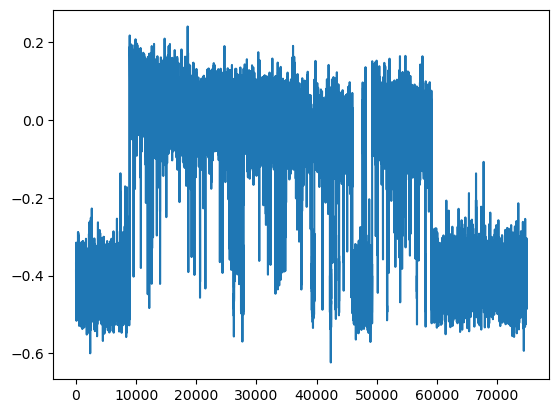

In [16]:
df["Raw"].plot()

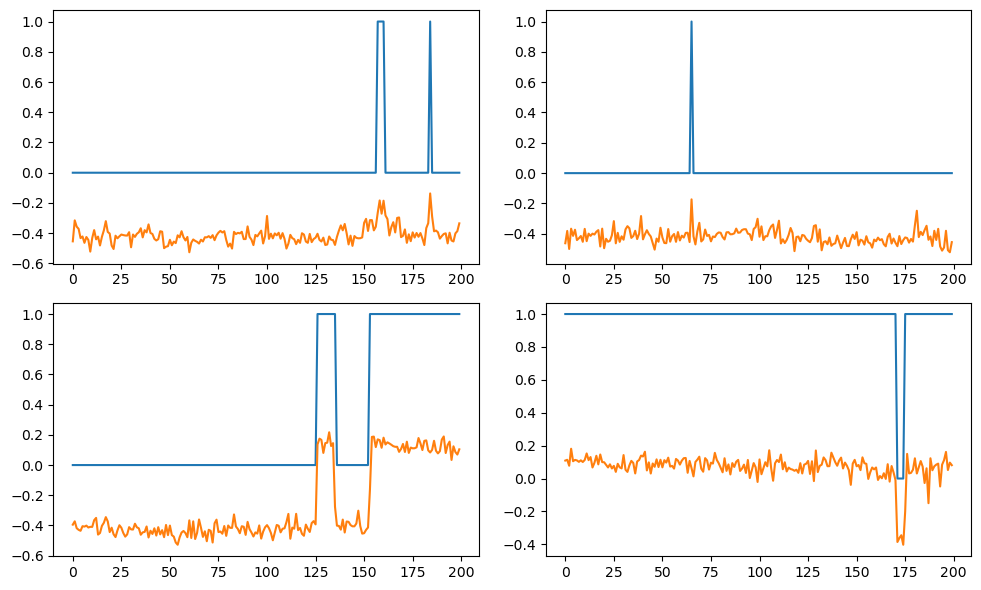

In [17]:
def plotter(data):
    # Create a figure with two subplots (panels)
    fig, axs = plt.subplots(2, 2, figsize=(10, 6))
     # Flatten the axs array for easy iteration
    axs = axs.flatten()
    
    for i in range(4):
        axs[i].plot(data[i])
        #axs[i].set_ylim([-200, 200])
    plt.tight_layout()
    plt.show()

plotter(training_data)

In [18]:
# Define the generator model

def make_generator_model():
    noise_input = tf.keras.layers.Input(shape=(100,))
    x = tf.keras.layers.Dense(128, activation='relu')(noise_input)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    
    # Output layer without activation
    raw_output = tf.keras.layers.Dense(9)(x)
    #Tickle the generator into the right ball park with the +10 etc...
    # Apply appropriate activations/scaling to each output
    #nE = tf.keras.layers.Lambda(lambda x: tf.abs(x) + 20)(raw_output[:, 0:1])  # Positive, non-zero
    To= tf.keras.layers.Lambda(lambda x: tf.abs(x)+ 1e-6)(raw_output[:, 0:1])  # Positive, non-zero
    Tc1 = tf.keras.layers.Lambda(lambda x: tf.abs(x)+ 1e-3)(raw_output[:, 1:2])  # Positive, non-zero
    #phase = tf.keras.layers.Lambda(lambda x: x * 2 * np.pi)(raw_output[:, 2:3])  # Any value, scaled to [0, 2π]
    Anoise = tf.keras.layers.Lambda(lambda x: tf.abs(x))(raw_output[:, 2:3])  # Positive
    Fnoise = tf.keras.layers.Lambda(lambda x: tf.abs(x))(raw_output[:, 3:4])  # Positive  
    scale = tf.keras.layers.Lambda(lambda x: tf.abs(x)+0.1)(raw_output[:, 4:5])  # Positive  should it be?
    offset = raw_output[:, 5:6]
    nSpikes = tf.keras.layers.Lambda(lambda x: tf.abs(x)+ 1)(raw_output[:, 6:7])
    Tc2 = tf.keras.layers.Lambda(lambda x: tf.abs(x)+ 1e-3)(raw_output[:, 7:8])  # Positive, non-zero
    To2 = tf.keras.layers.Lambda(lambda x: tf.abs(x)+ 1e-6)(raw_output[:, 8:9])  # Positive, non-zero
    output = tf.keras.layers.Concatenate()([To, Tc1, Anoise, Fnoise, scale, offset, nSpikes, Tc2, To2])
    #output = tf.keras.layers.Concatenate()([To, Tc])
    #output = tf.keras.layers.Lambda(lambda x: x * 5)(output)  # Multiply by 10
    
    return tf.keras.Model(inputs=noise_input, outputs=output)


# Define the discriminator model batch, record len, channels = events then noise
num_points = T.numpy().item()
def make_discriminator_model():
    input_shape = (size,2) 
    inputs = tf.keras.Input(shape=input_shape)

    # Reshape input to add channel dimension
    x = tf.keras.layers.Reshape((size, 2))(inputs)
    
    # 1D Convolutional layers
    x = tf.keras.layers.Conv1D(8, kernel_size=5, strides=2, padding='same', activation='leaky_relu')(x)
    x = tf.keras.layers.Conv1D(16, kernel_size=5, strides=2, padding='same', activation='leaky_relu')(x)
    x = tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, padding='same', activation='leaky_relu')(x)
    x = tf.keras.layers.Dropout(0.3) (x)
    
    # Global average pooling
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    """
    # Dense layers
    x = tf.keras.layers.Dense(256, activation='leaky_relu')(x)
    x = tf.keras.layers.Dense(128, activation='leaky_relu')(x)"""
    
    # Output layer
    outputs = tf.keras.layers.Dense(1)(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)


# Loss functions and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output, from_logits=True))

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)


In [19]:
# Training step
@tf.function
def train_step(real_data):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_params = generator(noise, training=True)
        #tf.print("generated_params:", generated_params[0])

        try:
            generated_data = tf.map_fn(sim_channel, generated_params, fn_output_signature=tf.float32)
        except:
            tf.print("sim_channel error")
            #return tf.constant(0, dtype=tf.float32), tf.constant(0, dtype=tf.float32)
            
        #tf.print("generated_data shape:", tf.shape(generated_data))
        
        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(generated_data, training=True)
        
        #tf.print("real_output:", real_output[0])
        #tf.print("fake_output:", fake_output[0])
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    #tf.print("gen_loss:", gen_loss)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

# Training loop
def train(dataset, epochs):
    steps_per_epoch = math.floor(num_samples / batch_size)
    #steps_per_epoch =2
    tf.print("steps per epoch", steps_per_epoch)
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        # Initialize loss accumulators for each epoch
        epoch_gen_loss = 0
        epoch_disc_loss = 0
        
        for step, batch in tqdm(enumerate(dataset), total=steps_per_epoch):
            #clear_output(wait=True)
            if step >= steps_per_epoch:
                break  # Move to the next epoch          
            try:
                gen_loss, disc_loss = train_step(batch)
                #tf.print("gen_loss",gen_loss)
                epoch_gen_loss += gen_loss
                #tf.print("epoch_gen_loss",gen_loss)
                epoch_disc_loss += disc_loss
            except Exception as e:
                print(f"Error during training: {e}")
                break

        #tf.print("epoch_gen_loss",epoch_gen_loss)
        # Calculate average losses for the epoch
        avg_gen_loss = epoch_gen_loss / steps_per_epoch
        avg_disc_loss = epoch_disc_loss / steps_per_epoch
        clear_output(wait=True)
        print(f"Epoch {epoch + 1}/{epochs} - "
              f"Generator Loss: {avg_gen_loss:.8f}, "
              f"Discriminator Loss: {avg_disc_loss:.8f}")
        
        # Generate and plot sine waves
        egs=2
        
        # Generate and plot sine waves
        EgNoise = tf.random.normal([egs, 100])
        #print("EgNoise", EgNoise[0])
        generated_params = generator(EgNoise, training=False)
        #print(steps_per_epoch)
        # Define parameter names
        param_names = ['To1', 'Tc1', 'Anoise', 'Fnoise', 'scale',"offset","nSpikes", "Tc2", "To2"]
        random_index1 = tf.random.uniform(shape=[], minval=0, maxval=egs-1, dtype=tf.int32)

        params_list = generated_params[random_index1].numpy().tolist()
        # Print each parameter with its name
        for name, param in zip(param_names, params_list):
            tf.print(f"{name}: {round(param, 2)}. ", end = "  ")
        """print("params", generated_params[0])"""
         
        gen_waves=[]
        for i in range(egs):
            gen_waves.append( sim_channel(generated_params[i]) )

        """
        # Create a figure with two subplots (panels)
        fig, axs = plt.subplots(egs, 1, figsize=(10, 6))
        for i in range(egs):
            axs[i].plot(gen_waves[i] )
            #axs[i].set_ylim([0,1])
        plt.tight_layout()
        plt.show()
        """
        #tf.print(tf.shape(gen_waves))
        random_index2 = tf.random.uniform(shape=[], minval=0, maxval=tf.shape(training_data)[0], dtype=tf.int32)

        biPlotter([gen_waves[random_index1],training_data[random_index2]], random_index1, random_index2)

        plt.show()
              
        if (epoch + 1) % 10 == 0:
            print(f"Completed {epoch + 1} epochs")
            plt.savefig(f"chanFigs/fig{epoch}.png")
        if writeNow:
            writeMe(epoch=epoch)
            


In [20]:
def biPlotter(data, n, m):
    # Create a figure with two subplots (panels)
    fig, axs = plt.subplots(2, 1, figsize=(10, 6))
    axs[0].plot(data[0] )
    axs[0].set_title(f"Generated Wave, record {n}")
    axs[1].plot(data[1] )
    axs[1].set_title(f"Training Data, record {m}")
    #axs[i].set_ylim([-200,200])
    plt.tight_layout()
    plt.show()
    

In [ ]:
def writeMe(samples=100, dt=0.1, epoch=0, file="output.parquet"):
    sampleNoise = tf.random.normal([samples, 100])
    generated_params = generator(sampleNoise, training=False)
    gen_waves=[]
    for i in range(samples):
        gen_waves.extend( sim_channel(generated_params[i]) )
    df = pd.DataFrame(gen_waves, columns=["Channels", "Noisy Current"])
    df["Time"] = dt * pd.Series(range(len(df)))
    df = df[["Time", "Channels", "Noisy Current"]]
    df.to_parquet(f"{epoch}_{file}")
    print(f"Data saved to {epoch}_{file}")
    

In [21]:
batch_size = 5
training_dataset = tf.data.Dataset.from_tensor_slices(
    training_data).shuffle(5000).batch(batch_size, drop_remainder=True).repeat()


In [22]:
learning_rate_value = 1e-4

# Convert the learning rate value to the appropriate dtype
generator_optimizer.learning_rate.assign(tf.cast(learning_rate_value, generator_optimizer.learning_rate.dtype))
discriminator_optimizer.learning_rate.assign(tf.cast(learning_rate_value, discriminator_optimizer.learning_rate.dtype))

Epoch 6/20000 - Generator Loss: 0.71874911, Discriminator Loss: 1.29218602
To1: 0.14.   Tc1: 0.13.   Anoise: 0.08.   Fnoise: 0.03.   scale: 0.36.   offset: -0.31.   nSpikes: 1.02.   Tc2: 0.18.   To2: 0.27.   

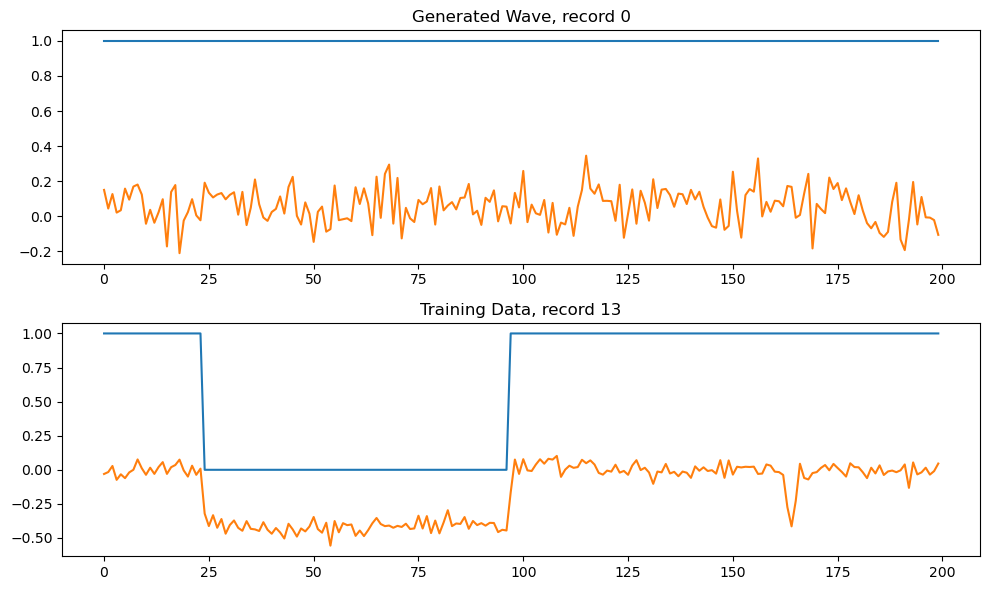

Epoch 7/20000


 67%|████████████████████████████████████████████████████████▋                            | 50/75 [2:49:34<1:24:47, 203.48s/it]

KeyboardInterrupt



In [23]:
epochs=20000
train(training_dataset, epochs)

In [ ]:
learning_rate_value = 1e-4

# Convert the learning rate value to the appropriate dtype
generator_optimizer.learning_rate.assign(tf.cast(learning_rate_value, generator_optimizer.learning_rate.dtype))
discriminator_optimizer.learning_rate.assign(tf.cast(learning_rate_value, discriminator_optimizer.learning_rate.dtype))

In [ ]:
x